# LTER/CTD Data Visualization

In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import requests
import io
from altair.expr import datum

In [2]:
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

## Data prep

First, we'll import the functions we created to convert AOOS and IOOS files into pandas dataframes and create dataframes for zooplankton and CTD. We can select for locations of interest in the IOOS data using 

In [3]:
import sys
sys.path.append("../ohw_lter_vis")
from load_Seward_CTD import make_CTD_dataframe
from load_Seward_zooplankton import make_zooplankton_dataframe

CTD_df = make_CTD_dataframe()
CTD_df.head()
zoo_df = make_zooplankton_dataframe(year=2012)
zoo_df.head()

,Cruise,Year,Month,Day,Time (hh:mm:ss AM/PM),Station,Tow Depth (m),Sonic Depth (m),latitude,longitude,...,Class,Subclass,Infraclass,Order,Suborder,Infraorder,Family,Genus,Species,time
1,TXS12,2012,5,9,13:45,GAK1,100,270,59.8448,-149.4663,...,Maxillopoda,Copepoda,Neocopepoda,Calanoida,NaN,NaN,Acartiidae,Acartia,longiremis,2012-05-09 13:45:00
2,TXS12,2012,5,9,13:45,GAK1,100,270,59.8448,-149.4663,...,Maxillopoda,Copepoda,Neocopepoda,Calanoida,NaN,NaN,Acartiidae,Acartia,longiremis,2012-05-09 13:45:00
3,TXS12,2012,5,9,13:45,GAK1,100,270,59.8448,-149.4663,...,Maxillopoda,Copepoda,Neocopepoda,Calanoida,NaN,NaN,Acartiidae,Acartia,NaN,2012-05-09 13:45:00
4,TXS12,2012,5,9,13:45,GAK1,100,270,59.8448,-149.4663,...,Maxillopoda,Copepoda,Neocopepoda,Calanoida,NaN,NaN,Acartiidae,Acartia,NaN,2012-05-09 13:45:00
5,TXS12,2012,5,9,13:45,GAK1,100,270,59.8448,-149.4663,...,Maxillopoda,Copepoda,Neocopepoda,Calanoida,NaN,NaN,Acartiidae,Acartia,NaN,2012-05-09 13:45:00


Cool! I want to find the mean salinity and temperature for every CTD sample location, which is date-time specific. So I'll group CTD on `time` and aggregate salinity and temp.

In [4]:
ctd_grouped = CTD_df.groupby(["time"]).agg({"salinity":"mean", "temperature":"mean"})
ctd_grouped = ctd_grouped.reset_index()
ctd_grouped.head()

,time,salinity,temperature
0,2012-05-04 05:21:55,32.156949,4.430698
1,2012-05-04 18:51:25,32.871290,5.504423
2,2012-05-04 20:20:55,33.508207,4.844291
3,2012-05-04 21:40:30,33.882555,4.128843
4,2012-05-05 00:03:30,33.878636,4.084673


Now I need to join these CTD summary stats to zooplankton samples. There are no common identifiers (keys) that match exactly between zooplankton and CTD dataframes, so I ran a "nearest neighbor" join based on the time parameter. Python makes you sort on date-time first (weird).

In [5]:
zoo_sorted = zoo_df.sort_values(by=['time'])
ctd_sorted = CTD_df.sort_values(by=['time'])

In [6]:
joined_ctd_zoo = pd.merge_asof(zoo_sorted, ctd_grouped, on='time', direction="nearest")

Now let's prep for some basic EDA. Let's find the temp and salinity profiles for Classes of zooplankton and compare those conditions to abundance to get an idea for habitat preferences.

In [7]:
zoo_class_df = joined_ctd_zoo.groupby(["Class","temperature","salinity"]).agg({"Abundance (no m-3)":"mean"})
zoo_class_df = zoo_class_df.reset_index()

In [8]:
zoo_class_df = zoo_class_df.rename(columns={'Abundance (no m-3)':'Abundance'})

## Altair visualizations

In [9]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['Class'], nearest=True)

base = alt.Chart(zoo_class_df).encode(
    alt.X('salinity:Q', scale=alt.Scale(domain=(31.5,34))),
    alt.Y('Abundance:Q'),
    color='Class:N'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=600
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

chart = points + lines

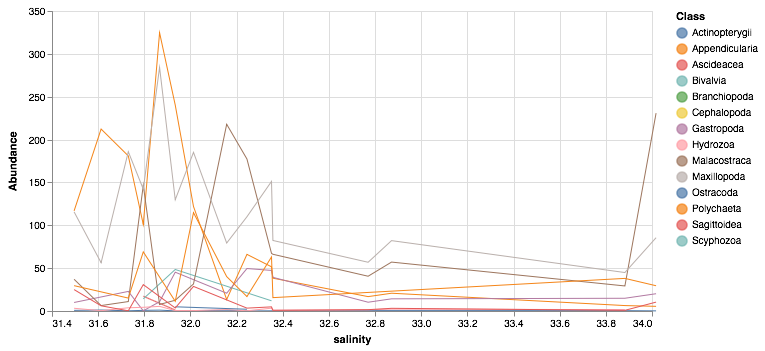

In [10]:
chart

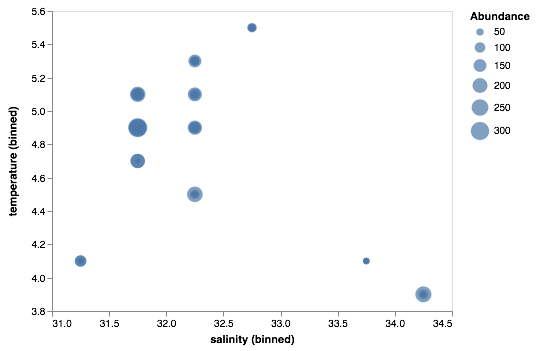

In [11]:
alt.Chart(zoo_class_df).mark_circle().encode(
    alt.X('salinity:Q', bin=True),
    alt.Y('temperature:Q', bin=True),
    size='Abundance:Q'
)

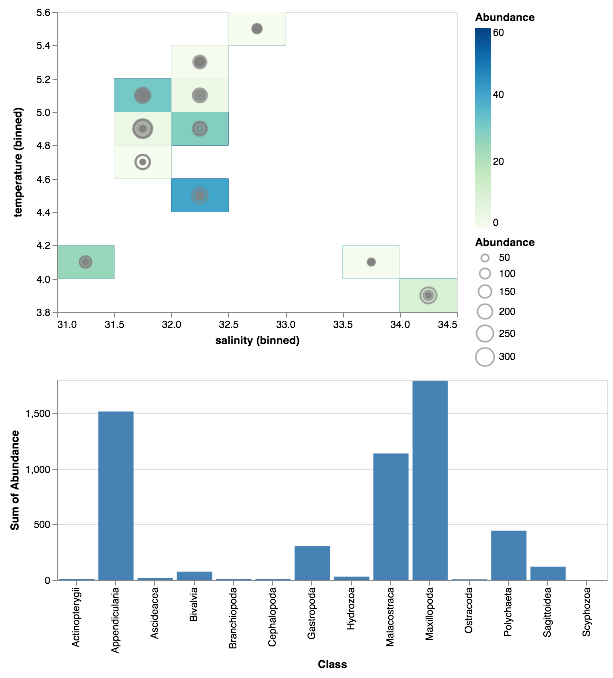

In [12]:
pts = alt.selection(type="single", encodings=['x'])

rect = alt.Chart(zoo_class_df).mark_rect().encode(
    alt.X('salinity:Q', bin=True),
    alt.Y('temperature:Q', bin=True),
    alt.Color('Abundance',
        scale=alt.Scale(scheme='greenblue', domain=(0,60)),
        legend=alt.Legend(title='Abundance')
    )
)

circ = rect.mark_point().encode(
    alt.ColorValue('grey'),
    alt.Size('Abundance',
        legend=alt.Legend(title='Abundance')
    )
).transform_filter(
    pts
)

bar = alt.Chart(zoo_class_df).mark_bar().encode(
    x='Class:N',
    y='sum(Abundance):Q',
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).properties(
    selection=pts,
    width=550,
    height=200
)

alt.vconcat(
    rect + circ,
    bar
).resolve_legend(
    color="independent",
    size="independent"
)

In [13]:
zoo_class_df.groupby('Class').agg({"Abundance":"sum"})

,Abundance
Class,
Actinopterygii,6.908997
Appendicularia,1516.473413
Ascideacea,18.353873
Bivalvia,74.483597
Branchiopoda,3.514220
Cephalopoda,0.396287
Gastropoda,305.522421
Hydrozoa,29.493849
Malacostraca,1139.193715


## Ignore!

This stuff is just my ill-fated attempt to do a nearest neighbor join based on lat/long. Liz's code using xarray would be good here--it'd be great to show a method for joining based on proximal spatial points!

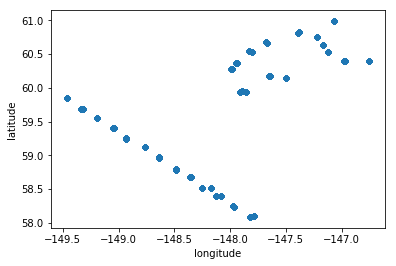

In [14]:
zoo_df.plot.scatter(x='longitude',y='latitude')

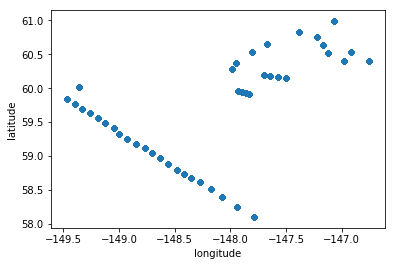

In [15]:
CTD_df.plot.scatter(x='longitude',y='latitude')

In [16]:
def dist(time1, long1, lat2, long2):
    return np.abs((lat1-lat2)+(long1-long2))

In [17]:
def find_station(lat, long):
    distances = CTD_coords.apply(
        lambda row: dist(lat, long, row['latitude'], row['longitude']), 
        axis=1)
    return CTD_coords.loc[distances.idxmin(), 'id_ctd']

In [18]:
coords_table = zoo_coords.apply(
    lambda row: find_station(row['latitude'], row['longitude']), 
    axis=1)

NameError: name 'zoo_coords' is not defined